# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [90]:
# Installing surprise library
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [91]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**

We'll do the following transformations:
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [92]:
# importiing the Dataset
rating = pd.read_csv("/content/drive/MyDrive/Data Science/IDSS MIT/Week 6 - Recomendation Systems/Assessment/ratings_Electronics.csv")

In [93]:
# checking how the dataset looks like
rating.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [94]:
# Setting new column names ['user_id', 'prod_id', 'rating', 'timestamp']
rating.columns = ['user_id', 'prod_id', 'rating', 'timestamp']


In [95]:
# dropping the 'timestamp' as we won't need it
rating.drop('timestamp', axis=1, inplace= True)

In [96]:
# checking if modification where successful
rating.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [97]:
# we'll Copy the data to another data frame
df = rating.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [98]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [99]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [100]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [101]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [102]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [103]:
df_final.shape

(65290, 3)

### **Check the number of rows and columns and provide observations.**

In [104]:
# Check the number of rows and columns and provide observations
print ('the dataframe has', df_final.shape[0], 'rows and', df_final.shape[1], 'columns')

the dataframe has 65290 rows and 3 columns


**Observations:**
* We went from 7,824,482 observations to 65,290.

### **Data types**

In [105]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**
* The rating data contains 65,290 observations and 3 columns.
* The 'rating' columns are both of numeric data type.
* The 'user_id' and 'prod_id' columns has the data type object.
* We'll make sure 'user_id' and 'prod_id' are not mixed type. As we will be using this column in subsequent steps.
* 'prod_id' is detected as object type, it may be mixed. So let's check if there are letters in 'prod_id', and let's also check if there are any 'string' type entry.


In [106]:
# Check for string type in 'prod_id' column
is_string = df_final['prod_id'].apply(lambda x: isinstance(x, str))

# Count the number of string entries in 'prod_id'
number_of_strings = is_string.sum()

print(f"Number of string entries in 'prod_id': {number_of_strings}")

Number of string entries in 'prod_id': 65290


In [107]:
# Check for letters in 'prod_id' column using regex
contains_letters = df_final['prod_id'].str.contains(r'[A-Za-z]', regex=True)

# Count the number of rows with letters in 'prod_id'
number_of_rows_with_letters = contains_letters.sum()

print(f"Number of rows with letters in 'prod_id': {number_of_rows_with_letters}")

Number of rows with letters in 'prod_id': 65265


In [108]:
# Check for string type in 'prod_id' column
is_string = df_final['user_id'].apply(lambda x: isinstance(x, str))

# Count the number of string entries in 'prod_id'
number_of_strings2 = is_string.sum()

print(f"Number of string entries in 'user_id': {number_of_strings2}")

Number of string entries in 'user_id': 65290


In [109]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**
* We checked that all rows in either 'prod_id' and 'user_id' are already of string type.
* No need to do anything further.

### **Checking for missing values**

**Check the percentage of missing values in each column**

In [110]:
# Check for missing values present and provide observations
pd.DataFrame(data={'% of Missing Values':round(df_final.isna().sum()/df_final.isna().count()*100,2)}).sort_values(by='% of Missing Values',ascending=False)

,% of Missing Values
user_id,0.0
prod_id,0.0
rating,0.0


**Observations:**

* We verify successfuly that there are no missing values in our dataset.

### **Summary Statistics**

In [111]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Observations:**

* Thre are 65290 ratings with a mean of 4.29 and a median of 5.0
* Given that the mean is lower than the median, it suggests a left-skewed distribution.
* The minimum and maximum values for rated products are 1.0 and 5.0 respectively
* The average user gives 5 stars to a product. In other words, this indicates that a large number of customers give 5 stars when rating a product.

### **Checking the rating distribution**

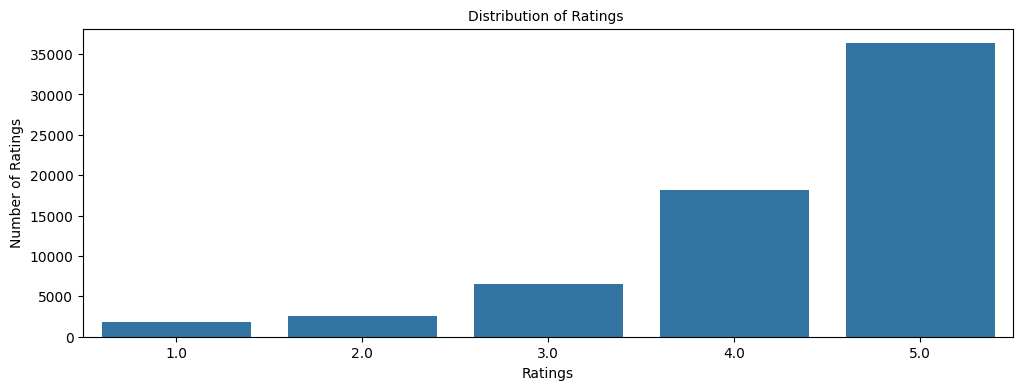

In [112]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=df_final)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [113]:
df_final['rating'].value_counts()

5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: rating, dtype: int64

In [114]:
df_final['rating'].value_counts(normalize=True)*100

5.0    55.621075
4.0    27.763823
3.0     9.926482
2.0     3.852045
1.0     2.836575
Name: rating, dtype: float64

**Observations:**
* As per the histogram, 5 stars rating has the highest rating count (~35,000K) and account for 55% of our dataset, followed by Rating 3 and 4, which have around 18k and 6.5K observations respectively, accounting for 27% and ~10% of our dataset respectively.
* There are very few ratings for 1 and 2 stars (2.5k)
* The distribution is heavily left-skewed, indicating that users are more inclined to give higher ratings.
* 5-star ratings are overwhelmingly more common than 1-star ratings, with the former being about 20 times as frequent.
* The high occurrence of 5-star ratings could reflect a tendency for satisfied users to provide feedback, or it could indicate a selection bias where only users who are very satisfied with a product choose to rate it.

### **Checking the number of unique users and items in the dataset**

In [115]:
# Number of total rows in the data and number of unique user id and product id in the data
# Finding the number of unique users
df_final['user_id'].nunique()

1540

In [116]:
# Finding the number of unique products
df_final['prod_id'].nunique()

5689

**Observations:**
* There are 1540 unique users and 5689 products in the data set.
* As per the number of unique users and products, there is a possibility of 1540 * 5680 = 96,388,600 ratings in the dataset. But we only have 62,590 ratings, i.e., not every user has rated every product in the dataset. So, we can build a recommendation system to recommend products to users which they have not interacted with.

###**Let's check how many interactions there is between users and products**

In [117]:
df_final.groupby(['user_id', 'prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [118]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

**Observations**:
* The sum is equal to the total number of observations (i.e. 62,590), which implies that **there is only one interaction between a product and a user.**


### **Users with the most number of ratings**

In [119]:
# Top 5 users based on the number of ratings
df['user_id'].value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
AOQLV2LSI9B2W      50
A2JRDFIGWTX50J     50
A3EHJ5519LG7TR     50
A3LSEIG2PIJYBL     50
A3BY5KCNQZXV5U     50
Name: user_id, Length: 1540, dtype: int64

**Observations:**

* The user with **user_id: A5JLAU2ARJ0BO** has interacted with the most number of products, i.e., 520 times.
* But still, there is a possibility of **5689-520 = 5169 more interactions** as we have 5689 unique users in the dataset.

### **Products with the most number of ratings - Most Popular**

In [120]:
# Top 5 products based on the number of ratings
df['prod_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B001UVCYN4      1
B001UW7YDS      1
B001UWKP0M      1
B001V2PGX2      1
B00LKG1MC8      1
Name: prod_id, Length: 48190, dtype: int64

**Observations:**

* The user with **prod_id: B0088CJT4U** has received the most amount of ratings, i.e. has been rated 206 times.
* But still, there is a possibility of **1540-206 = 1334 more interactions** as we have 1540 unique products in the dataset.
* It would be interesting to check what is the specific rating for each of these products: We'll plot the distribution of ratings for the most interacted products.


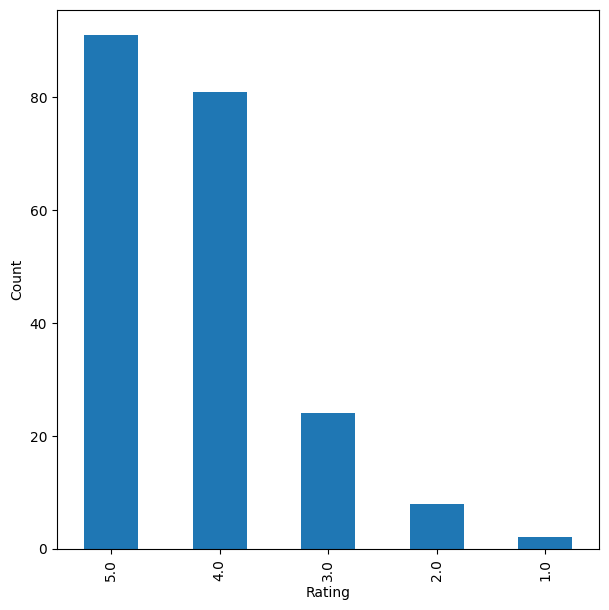

In [121]:
# Plotting distributions of ratings for the most interacted book

plt.figure(figsize=(7,7))

df_final[df_final['prod_id'] == "B0088CJT4U"]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')
plt.show()

**Observations:**

* We can see that the majority of the ratings for this product are 5.0, followed by 4 and 3.
* Because the count for ratings 1, 2 and 3 is much lower than ratings 5 and 4, this implies that the product is liked by the majority of users.

###**Distribution of the user-product interactions in the dataset**

In [122]:
# Finding user-product interactions distribution

count_interactions = df_final.groupby('user_id').count()['prod_id']

count_interactions

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: prod_id, Length: 1540, dtype: int64

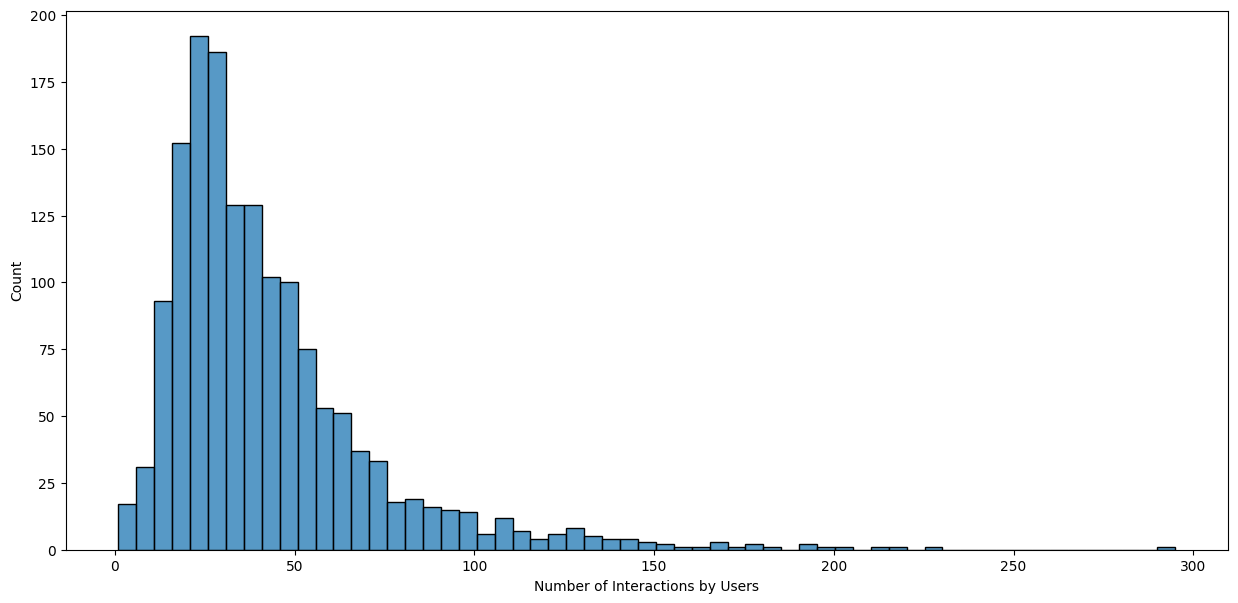

In [123]:
# Plotting user-item interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Observations:**

* The distribution is highly skewed to the right.
* There are many users with a small number of interactions and fewer users with a large number of interactions.
* Users with an extremely high number of interactions could be outliers and may require special consideration in the analysis. They might represent power users or could be bots or anomalies in the data.
* While building our models, we should keep in mind these factors to influence the model - a few users may be over-represented in the dataset and they would have a disproportionate impact on error metrics such as RMSE.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [124]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

# Sort the dataframe by average of ratings in the descending order
recommendations = final_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
recommendations.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [125]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction=10):

    # Finding books with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [126]:
res = list(top_n_products(final_rating, 5, 50))
print(f"the top 5 products with 50 minimum interactions are: {res}")

the top 5 products with 50 minimum interactions are: ['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [127]:
res = list(top_n_products(final_rating, 5, 100))
print(f"the top 5 products with 50 minimum interactions are: {res}")

the top 5 products with 50 minimum interactions are: ['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [128]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

###**Which Metric to focus on for this business case?**

Given the fixed number of recommendations (k=10) and the emphasis on relevance (>3.5 rating), a strategy prioritizing precision while maintaining a good recall seems most appropriate. This approach aligns with the goal of maximizing the relevance and impact of each recommendation, which is crucial for a platform like Amazon, where user satisfaction and conversion are key.

**Why should we have a slight priority for precision in recommendations ?**

* High precision recommendations are likely to enhance user engagement. When users consistently find the recommendations relevant, their trust in the platform increases, potentially leading to more frequent and prolonged usage.
* This approach aligns well with the objective of keeping users engaged and reducing friction in their browsing and shopping experience.
* By prioritizing precision, the system aims to minimize the risk of suggesting items that the user finds irrelevant, thereby reducing information overload and potential dissatisfaction.
* From a business perspective, precise recommendations can lead to higher conversion rates, as users are more likely to purchase items that closely align with their interests.

**While precision seems to be the most important metric, we should still be aware of recall:**
* By also keeping an eye on recall, we ensure that the system is not missing out on a significant number of relevant products.
* High recall helps in capturing a broad range of user interests by ensuring that the system does not overlook items that might be less obvious but still relevant to the user.
* By offering a broader range of relevant recommendations, high recall can enhance user satisfaction and engagement. Users are more likely to find something that appeals to them, even if it's not among the most obvious or popular choices.

Recall is particularly crucial in scenarios where failing to recommend potentially relevant items could result in missed sales opportunities. However, given Amazon's extensive product range, a slightly lower recall may be acceptable. This is because the sheer variety of available products reduces the risk of a 'missed opportunity', ensuring that the system still meets a wide range of user preferences and needs.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [129]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

- From the above formula, to compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [130]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.3, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** **using the cosine similarity.**

### **Building the user-user Similarity-based Recommendation System**

####**Baseline Model**

In [131]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Fit the model on the training data
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user, k = 10, threshold = 3.5)

RMSE: 1.0390
Precision:  0.852
Recall:  0.785
F_1 score:  0.817


**Observations:**

- The baseline model has `RMSE=1.0390` on the test set. This indicates that, on average, the predicted ratings deviate from the actual ratings by about 1.0390 points on the rating scale.
- Intuition of Recall - We are getting a **recall of ~0.785**, which means out of **all the relevant books, 78.5% are recommended**.
- Intuition of Precision - We are getting a **precision of ~ 0.852**, which means **out of all the recommended books, 85.2% are relevant**.
- Here **F_1 score** of the **baseline model is ~0.817**. It indicates that **most recommended books were relevant and relevant books were recommended**. This suggests the system is relatively effective in capturing the relevant items for recommendation

**Implications for the business:**
- In the context of providing a fixed number of recommendations (k=10), this high precision suggests that the system will make very few irrelevant recommendations, which is key to maintaining user trust and satisfaction. This aligns well with the goal of providing relevant recommendations to keep users engaged without overwhelming them with less relevant options.
- The high F1 score is a positive indicator that the system is performing well overall.
- The relavitevly good recall of 78.5% is beneficial for ensuring that users see a wide variety of items they might like, specially for a diverse user base with varied tastes and preferences such as amazon's. Here, we can be reassured that the system recommends a broad range of relevant products to users.

We can try to improve the performance by using **GridSearchCV to tune different hyperparameters** of the algorithm. Consistent with our objective of maintaining high precision, our tuning efforts will be geared towards improving recall and lowering the RMSE, provided that we can do so without compromising the current level of precision—or better yet, while increasing it.



**Individual user-item predictions**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [132]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.80   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8, details={'actual_k': 5, 'was_impossible': False})

**Observation:**
* The actual rating for this user-item pair is 5.00 and predicted rating is 3.8 by this similarity based baseline model. The difference is consistent with the RMSE value.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [133]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final['prod_id'] != "1400501466"]

,user_id,prod_id,rating
2081,A2ZR3YTMEEIIZ4,1400532655,5.0
2149,A3CLWR1UUZT6TG,1400532655,5.0
2161,A5JLAU2ARJ0BO,1400532655,1.0
2227,A1P4XD7IORSEFN,1400532655,4.0
2362,A341HCMGNZCBIT,1400532655,5.0
...,...,...,...
7824422,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824423,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824424,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0


* The **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.
* 65,284 users have not seen the product "1400501466"

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [134]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 2.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.9969324864734994, details={'actual_k': 2, 'was_impossible': False})

**Observation:**
* The predicted rating is 2.0 and was based on actua_k = 2, meaning the algorihtm found 2 neigbors.

### **Improving similarity-based recommendation system by tuning its hyperparameters - Tuned Recommender v1**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [135]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 5, 10],
              'sim_options': {'name': ['msd', 'cosine', 'Pearson'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9688596561430461
{'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [136]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options_opti = {'name': 'cosine',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options_opti, k=30, min_k=5, verbose=False)
# Training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9775
Precision:  0.844
Recall:  0.809
F_1 score:  0.826


**Observations**

The performance metrics point to a general enhancement across most aspects, with a marginal decline in precision:
- The tuned model has `RMSE=0.9775`  indicating a more accurate average of predicted ratings compared to the baseline model's `RMSE:1.0390`. This improvement reflects a more precise prediction capability.
- With a **recall of ~0.809**, the model shows a slight enhancement over the baseline's 0.785 recall, this suggests that the tuned model is better at recommending a larger portion of relevant products to users.
- A **precision of ~ 0.844**, slihgtly worse than the baseline model, as we increased the number of recomendations to m=30, a decrease in precision and an increase in recall is expected.
- Here **F_1 score** of the **baseline model is ~0.826**, a slightly better F_1 score than the baseline model. This increment indicates a more balanced system, effectively combining precision and recall, and is suggestive of an overall more robust recommendation process despite the slight precision dip.

While the precision has slighty decreased, the model has become more reliable in its predictions and recommendations as given by the other metrics.

**Individual user-item Prediction Evaluation**

- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [137]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.80   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8, details={'actual_k': 5, 'was_impossible': False})

In [138]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.29674200818327, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observation:**

- There is no difference in the prediction of the baseline model and the tuned model for this particular user `userId="A3LDPF5FMB782Z"` and `prod_id= "1400501466"`. Both models predicted the rating as 3.80, which is not so close to 5.
- The prediction on the `userId="A34BZM6S9L7QI4"` and `prod_id= "1400501466"` pair has changed however significantly. The baseline model estimated rating is 2.00 compared with 4.30 for the optimized model. This is a significant difference, we'll explore the reasons below.

* The prediction for the user-product pair was marked as **was_impossible: True**. This suggests that the **system could not find a minimum of k_min=5** neighbors that meet the similarity criteria required to make a prediction, which unders such circumstances, will resort to a fallback strategy to provide an estimate.

* Comparatively, The baseline model, was able to make a prediction using just 2 neighbors (actual_k: 2).

* The tuned model's reliance on a higher min_k threshold appears to be a limiting factor in dealing with sparse data. Its inability to find enough neighbors suggests that the model is potentially too restrictive, leading to fallback predictions rather than ones based on neighbor similarity.

* In contrast, the baseline model with its lower min_k default value (presumably default to k=1) seems more capable of making predictions in sparse scenarios, albeit potentially with less confidence in the recommendation quality.

**Overall, this reflects the underlying weakness of collaborative filtering when it comes to sparse data. It struggles to make accurate predictions when interaction history is limited for new users or items. This situation highlights the potential of alternative models like Matrix Factorization, which may offer a more robust solution in handling sparse data by effectively uncovering latent factors to predict user preferences, even with minimal historical interactions. This approach could provide a more effective means of addressing the limitations inherent in collaborative filtering methods, and we'll explore these below.**




###**Tuned Recommender - v2**

In [139]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40], 'min_k': [1, 3, 5, 10],
              'sim_options': {'name': ['msd', 'cosine', 'Pearson'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9698458326634117
{'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [140]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options_opti_v2 = {'name': 'cosine',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_v2 = KNNBasic(sim_options=sim_options_opti_v2, k=40, min_k=5, verbose=False)
# Training the algorithm on the trainset
similarity_algo_optimized_v2.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized_v2)

RMSE: 0.9774
Precision:  0.844
Recall:  0.808
F_1 score:  0.826


**Observations:**
* Providing a larger amount of hyperparamter with GridSearchCV did not result in a performance improvement over the tuned model v1.
* This experiment highlights the robustness of our tuned model v1.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [141]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0, k=5)

[1, 10, 17, 18, 28]

**Observations:**

* user 0 most similar users in terms of preferences are: 1, 10, 17, 18, and 28.

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [142]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [143]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine

recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, similarity_algo_optimized)

In [144]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_ID', 'predicted_ratings'])

,prod_ID,predicted_ratings
0,B0019EHU8G,5
1,B001TH7GUU,5
2,B001UI2FPE,5
3,B001V9KG0I,5
4,B002WE4HE2,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

####**Baseline Model**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [145]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(algo_knn_item)

RMSE: 1.0345
Precision:  0.833
Recall:  0.768
F_1 score:  0.799


**Observations:**

- The baseline model has `RMSE=1.0345`, the `Recall=0.768`, the `Precision=0.833`, and the `F_1 Score=0.799`on the test set.
- Overall, this model shows lower perfomrance than our previous user-based model.
- We'll try improving the performance by tuning hyperparameters by using `GridSearchCV`.

**Individual user-item prediction evaluation**

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [146]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.19   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1875, details={'actual_k': 16, 'was_impossible': False})

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [147]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 3, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 3, 'was_impossible': False})

**Observations:**

* The prediction of 4.19 for the user-item pair 'A3LDPF5FMB782Z' & '1400501466' is closer to the actual rating of 5.00, compared to our previous user-based models (i.e. 3.80) showing improved accuracy over previous user-based models.
* For 'A34BZM6S9L7QI4' & '1400501466', the item-based model's estimate of 4.00 aligns closely with the 4.30 rating from the optimized user-based model,

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [148]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9757082318058289
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [149]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options_opti = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
item_similarity_algo_optimized = KNNBasic(sim_options=sim_options_opti, k=20, min_k=6, verbose=False)

# Training the algorithm on the trainset
item_similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(item_similarity_algo_optimized)

RMSE: 0.9804
Precision:  0.833
Recall:  0.8
F_1 score:  0.816


**Observations**

The performance metrics point to a general enhancement across all aspects:

- The tuned item-based model shows an `RMSE=0.9804`, which is an improvement over the baseline item-based model's `RMSE=1.0345`.
- Both the tuned item-based model and the baseline item-based model have the same precision of 0.833.
- The tuned item-based model has a higher recall of 0.8 compared to the baseline's 0.768.
- The tuned item-based model achieves an F1 score of 0.816, outperforming the baseline's 0.799.

**Conclusion:**

The tuned item-based model demonstrates improvements over the baseline item-based model, particularly in RMSE and recall. However, it still falls slightly short compared to the best user-based model (tuned user-based model v1) in terms of overall performance metrics.

**Individual Prediction Evaluation**



- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [150]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
item_similarity_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.53   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.534653465346536, details={'actual_k': 16, 'was_impossible': False})

In [151]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
item_similarity_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.29674200818327, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**
* The model predicted a rating of 4.53, which is closer to the actual rating of 5.00. This indicates an improvement in prediction accuracy for this pair over previous models.
* The prediction for this pair is 4.30, identical to the estimate from the optimized user-based model. However, this prediction was made under the **'was_impossible': True** condition due to insufficient neighbors, suggesting reliance on the same fallback estimation strategy as above.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [152]:
item_similarity_algo_optimized.get_neighbors(0, k=5)

[9, 12, 13, 22, 28]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [153]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations_items = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, item_similarity_algo_optimized)

In [154]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations_items, columns=['prod_ID', 'predicted_ratings'])

,prod_ID,predicted_ratings
0,1400532655,4.296742
1,1400599997,4.296742
2,9983891212,4.296742
3,B00000DM9W,4.296742
4,B00000J1V5,4.296742


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [155]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9114
Precision:  0.854
Recall:  0.802
F_1 score:  0.827


**Observations**

* The SVD model outperforms both the tuned user-based and tuned item-based models in terms of RMSE (0.9114), indicating more accurate rating prediction values.
* It also has a higher precision (0.854) than both other models, suggesting that its recommendations are more relevant to the users.
* While the recall of the SVD model is slightly lower than the tuned user-based model, it is higher compared to the tuned item-based model, suggesting a better ability to identify and recommend relevant items.
* The F1 Score of the SVD model is marginally higher than both the user-based and item-based models, indicating a balanced performance between precision and recall, and a overall more precise prediction from this model.

**Conclusion**

The SVD model shows superior performance across most metrics, particularly in precision and RMSE, indicating it is more efficient at providing accurate and relevant recommendations. The marginally lower recall compared to the user-based model is outweighed by the overall gains in other areas. This suggests that for this dataset, a model-based collaborative filtering approach using SVD may be more effective than the neighborhood-based methods of the other two models.

**Individual user-item prediction envaluation**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [156]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.262585198727372, details={'was_impossible': False})

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [157]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.43   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.430784168423419, details={'was_impossible': False})

**Observations**

* The SVD model's prediction for the user-item pair A3LDPF5FMB782Z & 1400501466 is 4.26, which is closer to the actual rating of 5.00 than the tuned user-based model's prediction of 3.80, but not as close as the tuned item-based model's 4.53.
* For the user A34BZM6S9L7QI4 & item 1400501466, the SVD model predicts a rating of 4.43, which is higher than the tuned user-based model's estimation of 4.30. Notably, the user-based model flagged this prediction as 'was_impossible' due to sparse data, whereas the SVD model did not face this issue, which indicates better handling of sparse data by this model.

**Conclusion**

The SVD model demonstrates its robustness by providing more accurate and relevant predictions, even when other models encounter challenges with data sparsity, as evidenced by its ability to predict for A34BZM6S9L7QI4 without the 'was_impossible' flag, which both the tuned user-based and tuned item-based models encountered.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [158]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
gs_.fit(data)
# Best RMSE score
print(gs_.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8967169033480316
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [159]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD (n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.9034
Precision:  0.854
Recall:  0.797
F_1 score:  0.825


**Observations**
* The tuned SVD model achieves a lower RMSE than both the original SVD model and the other two types, **indicating it has the highest accuracy in predicting ratings.**
* Precision remains the same for both SVD models (0.854), outperforming all the user-based and item-based models. Suggesting this model is the best at giving relevant recommendations to users.
* The tuned SVD model has a slightly lower recall (0.797) compared to the original SVD (0.802) and the user-based model (0.809), but it is comparable to the item-based model (0.800).
* The F1 score of the tuned SVD model is very close to that of the original SVD model and marginally lower than the tuned user-based model (0.826), suggesting a slight trade-off between recall and precision on these magnitudes.

**Conclusion**

* The tuned SVD model, with its optimized parameters, demonstrates superior accuracy in rating predictions, as indicated by the lowest RMSE of all the models.
* This model maintains the highest precision of all.
* However, its recall is lower than the baselines SVD, however varies only slightly, with a difference at the third decimal digit, which makes it still very competitive with the other models.  
* The F1 score is marginally lower than the original SVD model, showing that there is a balance between precision and recall.

**Overall, the tuned SVD model proves to be the most effective at providing accurate and relevant recommendations among the models compared, confirming the strength of model-based collaborative filtering approaches for this dataset.**

**Evaluating single user-item pair predicitons:**

- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [160]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.20   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2017895361381195, details={'was_impossible': False})

In [161]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.28   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2778394371468496, details={'was_impossible': False})

**Observations:**

* The predicion on the first user-item pair is less accurate than the SVD baseline model (4.26), however generally more accurate our memory-based models.
* For the second user-item pair, the current model's estimate (4.28) is just below the SVD baseline's (4.43) but is closely aligned with the tuned user-based and item-based models' predictions (4.30 each).
* The SVD model's ability to predict ratings accurately, even in cases of sparse data, without resorting to fallback methods, suggests this model is more robust and prefered for this dataset.
* Given the SVD model's superior precision, F1 score, and lowest RMSE, coupled with a marginally lower recall, it stands out as the most effective model among those evaluated.

**Business implications:**
* From a business perspective, the tuned SVD model’s superior precision, coupled with its balanced recall, makes it the most suitable for Amazon's recommendation system. It effectively aligns with the business objectives of maximizing user engagement, satisfaction, and conversion rates.
* Furthermore, the model's proficiency in handling sparse data further underscores its suitability for a platform with such a large and extensive range of products such Amazon's, whom many of which might not have a large number of ratings or interactions. This model could still make predictions for less-rated items, being able to provide relevant recommendations to fresh new users, and handle new items effectively (addressing the cold start problem).

### **Improving recommendations with Stratified Sampling**

**Why considering stratified sampling?**

**Imbalances in the test set and stratified sampling:** we should ensure that each class is equally represented in both train and test sets. This can be done through stratified sampling.  

* This is true as our goal is to create a recommender system that provides equally good recommendations for all users, regardless of how many interactions they have had.

* In the context of our dataset with a long-tail distribution, most users have few interactions, and a smaller number have many interactions. If we split this data into training and testing sets randomly, it's likely that the test set would be dominated by users with few interactions simply because they are more numerous. This can lead to a situation where the recommender system is better at predicting for these low-interaction users because it has seen more examples of them, both in training and in testing.

* Thus, we should keep in mind such a model might not generalize well to users with more interactions because it hasn't been adequately trained or validated on similar examples.** This discrepancy can lead to a model that performs well on the majority class but poorly on the minority class, which in this case, are the users with a high number of interactions.

**Skewed User-Item distribution**

* The distribution of user-item interactions is highly skewed, and has a presence of outlisers, as such the RMSE may be disproportionally influenced by high-interaction users (outliers) as high number of interactions will contribute more individual errors to the RMSE calculation, potentially skewing the metric towards the parts of the dataset with more dense user interaction. It may also influence the accuracy of prediction for different classes of users, with different interaction profiles.

**How stratified sampling may help?**

By using stratified sampling, we ensure that both the training and testing sets include a representative distribution of users with few and many interactions:

* **Model Training:** The model learns from a dataset that is representative of the full range of user behaviors.

* **Model Evaluation:** The evaluation metrics we obtain from the test set (like RMSE and MAE) are more indicative of how the model will perform across the entire user base.

Let's split the data while trying to balance the distribution of user-item interactions equally in train and test sets.

In [162]:
df_final_copy = df_final.copy()

In [163]:
# Create a column for user counts
df_final_copy['user_count'] = df_final_copy.groupby('user_id')['user_id'].transform('count')

# Split your data into stratified train and test sets
# You can adjust the split ratio and random state as needed
train_df = df_final_copy.groupby('user_id', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=1))
test_df = df_final_copy.drop(train_df.index)

# Now, use this train and test DataFrame with Surprise
reader = Reader(rating_scale=(1, 5))

# Load the trainset
train_data = Dataset.load_from_df(train_df[['user_id', 'prod_id', 'rating']], reader)
trainset = train_data.build_full_trainset()

# Prepare the testset
testset = list(zip(test_df.user_id.values, test_df.prod_id.values, test_df.rating.values))

**We can now proceed to train the model on the trainset and evaluate it on the testset**

In [164]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized_stratified = SVD (n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized_stratified=svd_optimized_stratified.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized_stratified)

RMSE: 0.9090
Precision:  0.862
Recall:  0.804
F_1 score:  0.832


**Observations:**
* The stratified sampling approach led to the highest performance metrics across all models tested, establishing it as the most effective method in our analysis.
* This outcome validates our hypothesis about the imbalance in the original train and test sets. By ensuring a more balanced distribution, we achieved notable improvements in precision, accuracy, and recall compared to the non-stratified SVD model.


**Evaluating single user-item pair predicitons:**

- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [165]:
# Use svd_optimized_stratified model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized_stratified.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.51   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.5126692261910213, details={'was_impossible': False})

In [166]:
# Use svd_optimized_stratified model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized_stratified.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.05   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.050057998401579, details={'was_impossible': False})

  **Observations:**
  * The first user-item pair prediction is 3.50 compared to the actual rating of 5.00. This represents a significant deviation and indicates lower prediction accuracy for this pair in the stratified SVD model.

### **Model 4 : Hybrid Recommender - SVD and KNN**

**First, lets pick some algorithms to include into our hybrid recommender system. We'll choose three.**
* Collaborative Filtering - **our user-based similarity model**
* Matrix Factorization - **our tuned SVD trained on stratified sample**
* And the third one is a **co-clustering model**: we'll go ahead and train this one first, before implementing it into the hybrid recommender.


#### **Co-clustering Model**

Let's import the necessary libraries to train our co-clustering model

In [167]:
from surprise import CoClustering
from surprise import PredictionImpossible
from surprise import AlgoBase

In [168]:
# Initialize the CoClustering model
co_cluster_model = CoClustering(random_state=1)

# Train the model on the trainset
co_cluster_model.fit(trainset)

# check the performance of this model on the test set
precision_recall_at_k(co_cluster_model, k=10, threshold=3.5)

RMSE: 0.9794
Precision:  0.867
Recall:  0.765
F_1 score:  0.813


**Let's try improving the model with hyperparameter tuning, before passing it to the hybrid recommender**

In this model, clusters are assigned using a straightforward optimization method, much like k-means.

**The parameters we can tune are the following:**
* n_cltr_u (int) – Number of user clusters. Default is 3.
* n_cltr_i (int) – Number of item clusters. Default is 3.
* n_epochs (int) – Number of iteration of the optimization loop. Default is 20.

In [169]:
# Define the parameter grid to search over
param_grid = {
    'n_cltr_u': [1, 3, 6],
    'n_cltr_i': [1, 3, 6],
    'n_epochs': [10, 20, 30],
    'random_state': [1],
    'verbose': [True],
}

# Create an instance of the co-clustering estimator with default hyperparameters
co_cluster = CoClustering

# Create an instance of GridSearchCV, passing the co-clustering estimator and the parameter grid as arguments
grid_search = GridSearchCV(co_cluster, param_grid=param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(data)

# Best RMSE score
print(grid_search.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_search.best_params['rmse'])


0.9438576919698475
{'n_cltr_u': 1, 'n_cltr_i': 1, 'n_epochs': 10, 'random_state': 1, 'verbose': True}


Let's train the model with the optimal paramters found

In [170]:
# Initialize the CoClustering model
co_cluster_model_optimized = CoClustering(n_cltr_u=1, n_cltr_i=1, n_epochs=10, random_state=1)

# Train the model on the trainset
co_cluster_model_optimized.fit(trainset)

# check the performance of this model on the test set
precision_recall_at_k(co_cluster_model_optimized, k=10, threshold=3.5)

RMSE: 0.9556
Precision:  0.864
Recall:  0.77
F_1 score:  0.814


**Observations:**
* There is an overall marginal improvement over the baseline co-cluster model for this model except for a slight decrease in precision.
* Now that we have built the co-clustering model, in this section we'll combine the three models we've chosen and experiment with hybrid approaches.

#### **Building the Hybrid Recommender from the proposed three models**



**As mentioned earlier, our hybrid system integrates the following models:**

* A user-based collaborative filtering model (tuned for optimal performance).
* An SVD (Singular Value Decomposition) model, fine-tuned on a stratified sample to handle diverse data effectively.
* A tuned co-clustering model, aimed at capturing latent structures in user-item interactions.

**The method used to combine the predictions of the individual models are the following:**
* Equal weights averaging in this section
* ANNEXE: performance weighted averaging - models that exhibit higher accuracy (lower RMSE, for instance) on a validation set are given more influence in the final prediction.

**Hybrid recommender with Equal weights averaging:**

In [171]:
class HybridRecommender_baseline(AlgoBase):
    def __init__(self, models):
        AlgoBase.__init__(self)
        self.models = models

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        # Train each model on the trainset
        for model in self.models:
            model.fit(trainset)

    def estimate(self, u, i):
        # Check if user and item are known in the trainset
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unknown.')

        # Calculate the average of the predictions from each model
        algo_results = np.array([model.predict(u, i).est for model in self.models])
        return np.mean(algo_results)

In [172]:
# Assuming user_based_model, svd_stratified_model, and co_clustering_model are your pre-defined models
hybrid_model_baseline = HybridRecommender_baseline(models=[similarity_algo_optimized, svd_optimized_stratified,co_cluster_model_optimized ])

# Train the hybrid model
hybrid_model_baseline.fit(trainset)

In [173]:
# check the performance of this model on the test set
precision_recall_at_k(hybrid_model_baseline, k=10, threshold=3.5)

RMSE: 0.9921
Precision:  0.838
Recall:  0.81
F_1 score:  0.824


**Observations:**

* Despite a slightly higher recall and competitive precision, our hybrid models did not surpass the performance of our best SVD model, with an RMSE approximately 10% higher.

* The single, well-tuned SVD model emerged as a more effective solution, demonstrating its robust capability to effectively capture key patterns in the data over this hybrid approach.

**Further Experimentations:**

* The mixed results from our hybrid models could stem from overlapping weaknesses among the individual models, preventing a significant performance enhancement.

* The chosen methods for combining model predictions may not be optimal for our specific models and dataset. Future efforts could explore different model combinations and weighting strategies.

* Exploring other hybrid strategies like stacking, blending, autoencoders, and Neural Collaborative Filtering could provide new insights and potentially better performance.


### **Which Model for Amazon’s Dataset?**


**Matrix Factorization with Biases (our tuned SVD model):**

* After comprehensive analysis and comparison, **the tuned SVD model trained on the stratified sample** emerges as the most suitable for Amazon's recommendation system. The model has demonstrated the best performance across most metrics for Amazon's dataset and **is particularly preferred for its high precision**. It achieved a low RMSE (0.9090), indicating its predictions are, on average, closest to the true ratings. Its precision is the highest (0.862), suggesting a strong ability to recommend products users find relevant. While its recall (0.804) which is very competitive as the second best, however especially when coupled with the highest F1 score (0.832), indicative of high accuracy and a balanced performance.

* This model based on SVD algorithm is robust, capable of handling sparse data efficiently, and doesn't rely on fallback strategies as much as memory-based models. This is crucial for Amazon's diverse and extensive product catalog, ensuring that even less popular items can be recommended accurately.

-------------------------------------------
-------------------------------------------

**Further Discussion**
* **For a diverse and large array of users:** Given that user-user and item-item collaborative filtering models struggle with the cold start problem, it is less desirable for a business such as amazon with a very high number of new users and items, and very sparse data.
* **For a more accurate prediction overall**: The SVD approach scales better and offers more relevant and accurate recommendations overall.
* **For diverse, frequently changing inventory:** SVD is more suitable as it can adapt to new products and users more quickly than memory-based models.


### **Actionable Insights and Recommendations for Amazon**

* **Implement the SVD model, fine-tuned on a stratified sample (let's called it 'our best SVD model')**: Given its high precision, accuracy, and balanced recall, it's ideal for a diverse platform like Amazon. It ensures user satisfaction and increased conversion rates.

* **Implement a Cold Start Strategy and data-collection for low interaction users:** For new products and users, incorporate strategies to collect data an improve the model predictions, such strategy could be asking new users to rate items they've previously used or purchased or recommending popular or trending items initially.

* **Diversify Recommendation Strategies:** segmenting users based on their interaction levels and using different models could help improve recommendations and each model's effectiveness. For users with many interactions, the current model works well. For those with fewer interactions, strategies to bolster the amount of data (like combining content-based filtering) could be implemented. Furthermore, combining high recall and high precision models depending on diverse scenarios could be an effective strategy to improve data collection and user experience.

* **Ethical and Fairness Considerations:** Monitor for biases in recommendations, ensuring that all products and users are treated fairly by the recommendation system. Diversify the types of products recommended to avoid over-concentration on particular items or categories.

### **Further Improvements**

* **Diverse User Needs:** Different users have varying levels of interaction history, preferences, and shopping behavior. A one-size-fits-all model might not get the best results while trying to predict for such diverse needs. Hence, we could use a hybrid approach, combining multiple models to cater to this diversity.

* **Dynamic Recommendations:** We could think of systems that weight different models based on the current user context. For instance, segmenting new users, high-interaction users. New users might receive recommendations generated by a model that's better at handling cold-start scenarios and better at recommending a broader catalog of products - excells at recall, while regular users might receive recommendations from a model that excels in personalization.

* **Exploring Advanced Techniques:** Further experiment with hybrid models, neural collaborative filtering and autoencoders could be considered to further improvement particularly if we consider the dataset to contains more complex patterns not fully captured by current models.

###**ANNEXE: Hybrid model experimentation**

Hereunder, we experiment with **perfomrance-based averaging** of our three models chosen for building the hybrid recommender.

In [174]:
class HybridRecommender_weighted(AlgoBase):
    def __init__(self, models):
        AlgoBase.__init__(self)
        self.models = models
        self.testset = testset

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        # Training each model on the trainset
        for model in self.models:
            model.fit(trainset)

        # Calculate the performance of each model on the validation set
        performances = []
        for model in self.models:
            predictions = model.test(self.testset)
            performance = accuracy.rmse(predictions)
            performances.append(performance)

        # Normalize the performances to get weights
        total_performance = sum(performances)
        self.weights = [performance / total_performance for performance in performances]

    def estimate(self, u, i):
        # Check if user and item are known in the trainset
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unknown.')

        # Calculate the weighted average of the predictions from each model
        algo_results = np.array([model.predict(u, i).est for model in self.models])
        weighted_results = algo_results * self.weights
        return np.sum(weighted_results)


In [175]:
# Plugging the models into our hybrid class: similarity_algo_optimized, svd_optimized_stratified, and co_cluster_model_optimized are our pre-defined models
hybrid_model_weighted = HybridRecommender_weighted(models=[similarity_algo_optimized, svd_optimized_stratified, co_cluster_model_optimized])

# Train the hybrid model & return the RMSE
hybrid_model_weighted.fit(trainset)

RMSE: 0.9708
RMSE: 0.9090
RMSE: 0.9556


In [176]:
# check the performance of this model on the test set
precision_recall_at_k(hybrid_model_weighted, k=10, threshold=3.5)

RMSE: 0.9921
Precision:  0.838
Recall:  0.81
F_1 score:  0.824


**Observations**

* This model, additionally to adding complexity did not provide any performance gains over the other model.